### 1. Importing Libraries and Dataset

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### 2. Loading the dataset into a pandas DataFrame

In [65]:
df = pd.read_csv(r"C:\Users\ysanc\Desktop\ML Projects\Box Office Revenue Prediction\Data\boxoffice.csv", encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


#### 2.1 Checking Dataset Size

In [45]:
df.shape

(2694, 10)

#### 2.2 Checking Data Types

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


### 3. Exploring the Dataset

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
domestic_revenue,2694.0,1.508539e+08,8.579997e+07,827765.0,7.673272e+07,152572473.5,2.247314e+08,2.998107e+08
world_revenue,2694.0,7.719177e+08,4.284414e+08,3261301.0,3.991135e+08,766555142.5,1.143920e+09,1.499310e+09
opening_revenue,2694.0,9.971321e+07,5.721762e+07,138569.0,5.033848e+07,99814175.0,1.489805e+08,1.999336e+08
opening_theaters,2694.0,2.263039e+03,1.298559e+03,10.0,1.161000e+03,2271.5,3.392250e+03,4.499000e+03
budget,2694.0,1.537996e+08,8.557624e+07,5197977.0,7.861876e+07,156256716.0,2.274832e+08,2.998597e+08
release_days,2694.0,9.089755e+01,5.089404e+01,1.0,4.700000e+01,91.0,1.350000e+02,1.790000e+02


#### 3.1 Checking Missing Values

In [48]:
df.isnull().sum() * 100 / df.shape[0]

title               0.0
domestic_revenue    0.0
world_revenue       0.0
distributor         0.0
opening_revenue     0.0
opening_theaters    0.0
budget              0.0
MPAA                0.0
genres              0.0
release_days        0.0
dtype: float64

### 4. Handling Missing Values

In [49]:
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()

np.int64(0)

#### 4.1 Cleaning Numeric Columns Stored as Strings

In [50]:
df['domestic_revenue'] = df['domestic_revenue'].astype(str).str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].astype(str).str.replace(',', '') 
    
    temp = (~df[col].isnull()) 
    df[temp][col] = df[temp][col].convert_dtypes(float) 

    df[col] = pd.to_numeric(df[col], errors='coerce')

### 5. Visualizing MPAA Rating Distribution

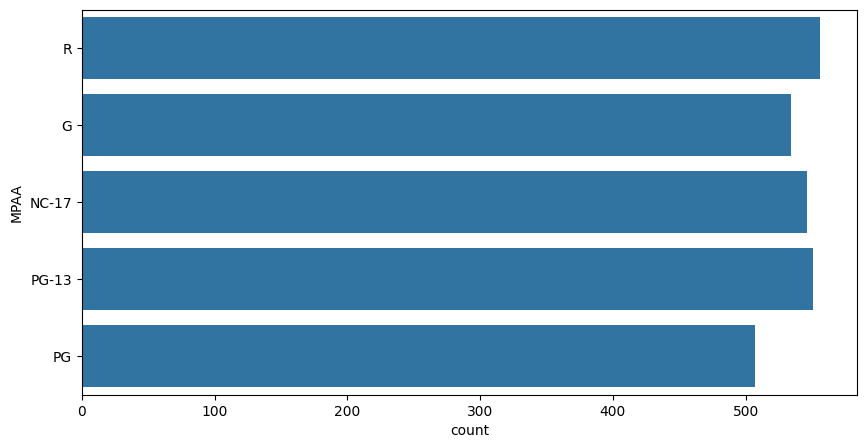

In [51]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()

### 5.1 Average Domestic Revenue by MPAA Rating

In [52]:
df.groupby('MPAA')['domestic_revenue'].mean()

MPAA
G        3.426099e+07
NC-17    3.452006e+07
PG       3.697347e+07
PG-13    3.510989e+07
R        3.670206e+07
Name: domestic_revenue, dtype: float64

### 6. Visualizing Distributions of Key Numeric Features

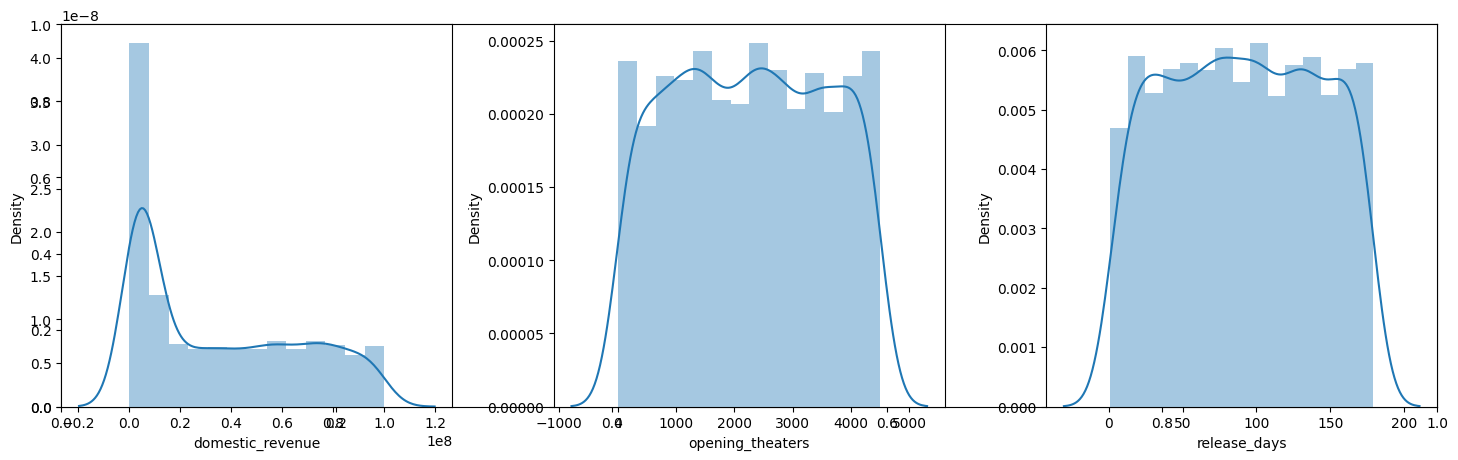

In [53]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

### 7. Detecting Outliers Using Boxplots

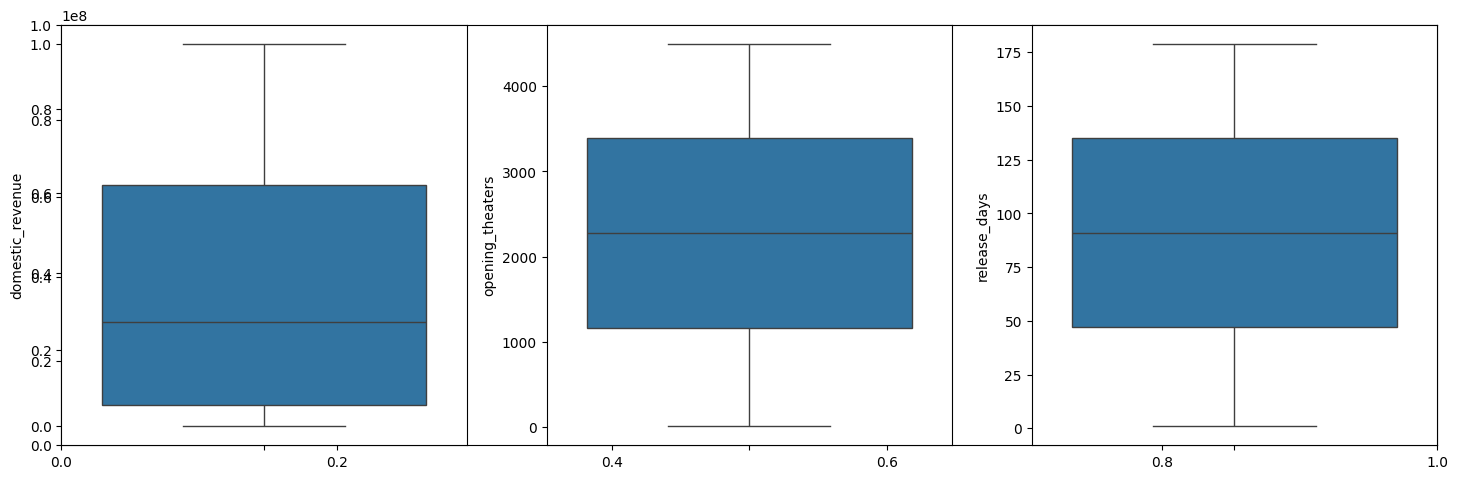

In [54]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()

We can observe that there are no outliers in the above features.

### 8. Applying Log Transformation to Numeric Features

In [55]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x))

#### 8.1 Checking Distributions After Log Transformation

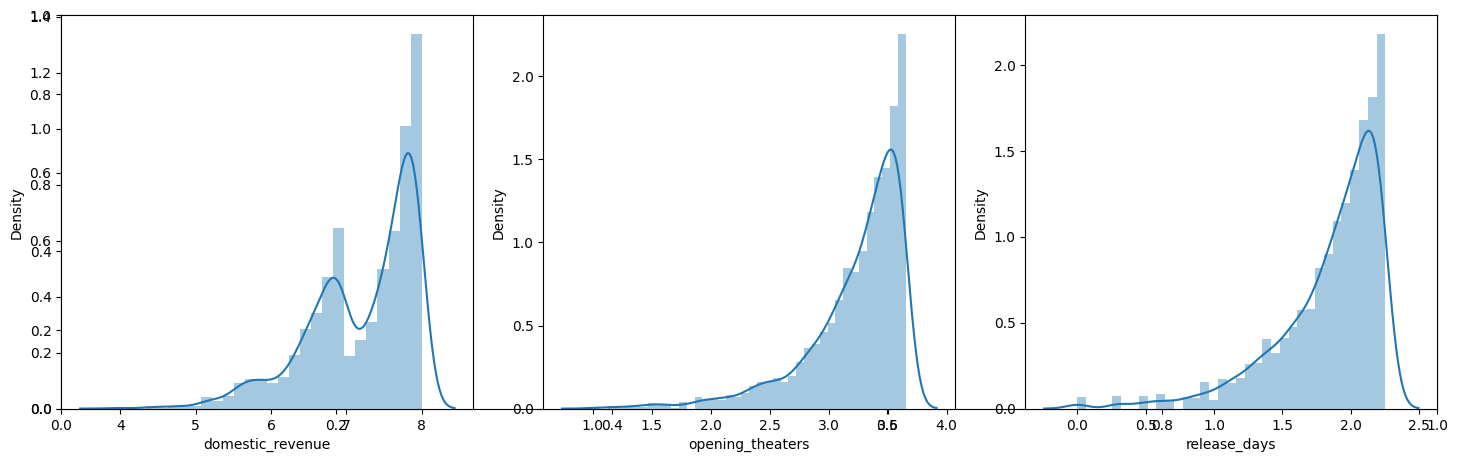

In [56]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

### 9. Converting Movie Genres into Numeric Features

In [57]:
vectorizer = CountVectorizer() 
vectorizer.fit(df['genres']) 
features = vectorizer.transform(df['genres']).toarray() 

genres = vectorizer.get_feature_names_out() 
for i, name in enumerate(genres): 
	df[name] = features[:, i] 

df.drop('genres', axis=1, inplace=True)

#### 9.1 Removing Rare Genre Columns with Mostly Zero Values

In [58]:
removed = 0

if 'action' in df.columns and 'western' in df.columns:
    for col in df.loc[:, 'action':'western'].columns: 
        
        if (df[col] == 0).mean() > 0.95: 
            removed += 1
            df.drop(col, axis=1, inplace=True) 

print(removed) 
print(df.shape)

0
(2694, 14)


### 10. Encoding Categorical Columns into Numbers

In [59]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

### 11. Visualizing Strong Correlations Between Numeric Features

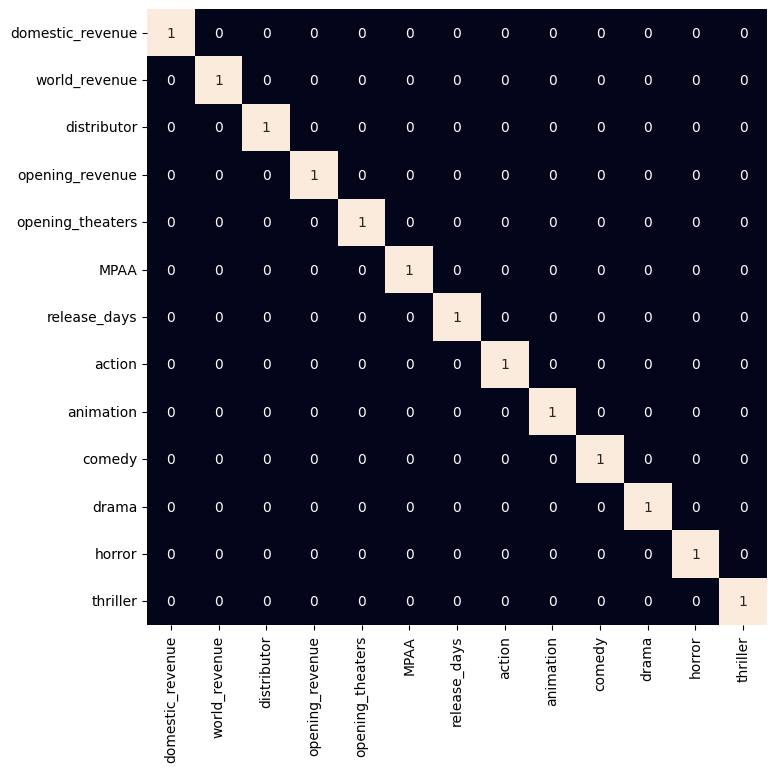

In [60]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.select_dtypes(include=np.number).corr() > 0.8, 
            annot=True, 
            cbar=False) 
plt.show()

### 12. Preparing Data for Model Training and Validation

In [61]:
features = df.drop(['title', 'domestic_revenue'], axis=1) 
target = df['domestic_revenue'].values 

X_train, X_val, Y_train, Y_val = train_test_split(features, target, 
									test_size=0.1, 
									random_state=22) 
X_train.shape, X_val.shape

((2424, 12), (270, 12))

#### 12.1 Normalizing Features for Better Model Training

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### 13. Training the XGBoost Regression Model

In [63]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### 14. Evaluating Model Performance on Training and Validation Sets

In [64]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
import numpy as np

# Predictions
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

# Training Metrics
print('Training MAE       :', mae(Y_train, train_preds))
print('Training RMSE      :', np.sqrt(mse(Y_train, train_preds)))
print('Training R² Score  :', r2_score(Y_train, train_preds))

# Validation Metrics
print('Validation MAE     :', mae(Y_val, val_preds))
print('Validation RMSE    :', np.sqrt(mse(Y_val, val_preds)))
print('Validation R² Score:', r2_score(Y_val, val_preds))

Training MAE       : 0.16389261202885838
Training RMSE      : 0.22056073293961442
Training R² Score  : 0.9040299884586872
Validation MAE     : 0.621778134751346
Validation RMSE    : 0.7650887975353712
Validation R² Score: -0.3457411379354336


In [67]:
### 15. Save the Model and Scaler
import joblib

# Save the model
joblib.dump(model, '../models/xgboost_model.pkl')
# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')
# In your training notebook
feature_names = features.columns.tolist()
joblib.dump(feature_names, '../models/feature_names.pkl')

['../models/feature_names.pkl']